In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [24]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline



In [25]:
from fastai.vision import *

In [26]:
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

In [27]:
path = Path('../input/planets-dataset/planet/planet/')

In [28]:
train_df = pd.read_csv(path/'train_classes.csv')
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [29]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [30]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_classes.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(label_delim=' '))

/opt/conda/lib/python3.7/site-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [31]:
data = (src.transform(tfms, size=128)
        .databunch(bs=64).normalize(imagenet_stats))

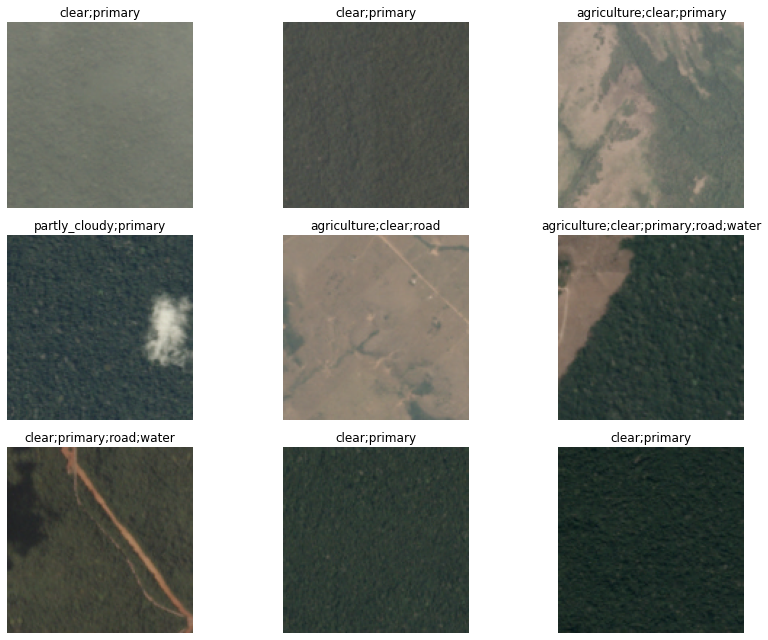

In [32]:
data.show_batch(rows=3, figsize=(12, 9))

**Getting to Training**

In [33]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, models.resnet50, metrics=[acc_02, f_score])

/opt/conda/lib/python3.7/site-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [34]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (32384 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: ../input/planets-dataset/planet/planet;

Valid: LabelList (8095 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
clear;primary;road,clear;primary;water,clear;conventional_mine;habitation;primary;road;water,cloudy,agriculture;clear;cultivation;cultivation;habitation;primary;road;water
Path: ../input/planets-dataset/planet/planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(

In [35]:
learn.lr_find()

Exception: [Errno 30] Read-only file system: '../input/planets-dataset/planet/planet/models'
Can't write to '../input/planets-dataset/planet/planet/models', set `learn.model_dir` attribute in Learner to a full libpath path that is writable

In [ ]:
learn.recorder.plot()

In [36]:
lr = 0.01
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.132533,0.114622,0.943720,0.903509,56:08
1,0.111284,0.101414,0.947470,0.912385,56:19
2,0.101132,0.090164,0.952432,0.921790,56:20


KeyboardInterrupt: 

In [37]:
learn.save('planet-amazon-stage-1')

Exception: [Errno 30] Read-only file system: '../input/planets-dataset/planet/planet/models'
Can't write to '../input/planets-dataset/planet/planet/models', set `learn.model_dir` attribute in Learner to a full libpath path that is writable

In [38]:
learn.export()

OSError: [Errno 30] Read-only file system: '../input/planets-dataset/planet/planet/export.pkl'

In [39]:
dataframes = []

for directory in ('test-jpg', 'test-jpg-additional'):
    test = ImageList.from_folder(path/directory)
    learn = load_learner(path, test=test)
    preds, _ = learn.get_preds(ds_type=DatasetType.Test)
    thresh = 0.2
    labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
    fnames = [f.name[:-4] for f in learn.data.test_ds.items]
    df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])
    dataframes.append(df)

NameError: name 'ImageItemList' is not defined

In [ ]:
df = pd.concat(dataframes)
df.to_csv(path/'submission.csv', index=False)
df.head()